Author: Kaushik Raghupathruni

In [178]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from PIL import Image, ImageEnhance
from skimage.feature import hog
import cv2
import xml.etree.ElementTree as ET
from svgpathtools import parse_path
from collections import defaultdict
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

Dataset Analysis

In [179]:
# Paths
ROOT = Path("dataset")
PAGES_DIR = ROOT / "images"
SVG_DIR = ROOT / "locations"
INDEX_TSV = ROOT / "transcription.tsv"
KEYWORDS_TSV = ROOT / "keywords.tsv"
DEST_DIR = ROOT / "words"
DEST_DIR.mkdir(parents=True, exist_ok=True)
TRAIN_PATH = ROOT / "train.tsv"
VALIDATION_PATH = ROOT / "validation.tsv"

In [180]:
# Parameters
RESIZE_HEIGHT = 64
DTW_BAND_RATIO = 0.25

In [181]:
# Load splits
train_pages = set(line.strip() for line in TRAIN_PATH.open())
val_pages = set(line.strip() for line in VALIDATION_PATH.open())

def clean_word(word):
    """Cleans word by removing hyphens but keeping special tokens"""
    # Split by hyphens and keep all parts (including s_* tokens)
    parts = word.split('-')
    # Join all parts together (removes hyphens but keeps special tokens)
    cleaned = ''.join(parts)
    return cleaned.lower()

# Load keywords (after cleaning)
keywords = set()
with KEYWORDS_TSV.open() as f:
    for line in f:
        original_keyword = line.strip()
        cleaned_keyword = clean_word(original_keyword)
        if cleaned_keyword:  # Skip empty strings
            keywords.add(cleaned_keyword)

# Load transcription index
index = []
with INDEX_TSV.open() as f:
    for locator, word in csv.reader(f, delimiter="\t"):
        cleaned = clean_word(word)
        if cleaned in keywords:
            index.append({
                'id': locator,
                'keyword': cleaned 
            })
            

print(index)

[{'id': '270-01-03', 'keyword': 'orders'}, {'id': '270-01-05', 'keyword': 'instructionss_pt'}, {'id': '270-04-02', 'keyword': 'orders'}, {'id': '270-04-08', 'keyword': 'send'}, {'id': '270-08-01', 'keyword': 'twelve'}, {'id': '270-08-02', 'keyword': 'hundred'}, {'id': '270-09-01', 'keyword': 'captain'}, {'id': '270-10-09', 'keyword': 'captain'}, {'id': '270-12-03', 'keyword': 's_gw'}, {'id': '270-16-02', 'keyword': 'officers'}, {'id': '270-17-02', 'keyword': 'fort'}, {'id': '270-17-03', 'keyword': 'cumberland'}, {'id': '270-17-05', 'keyword': 'colonel'}, {'id': '270-21-05', 'keyword': 'place'}, {'id': '270-24-08', 'keyword': 'de'}, {'id': '270-25-07', 'keyword': 'receive'}, {'id': '270-26-02', 'keyword': 'instructionss_pt'}, {'id': '270-28-02', 'keyword': 'men'}, {'id': '270-33-04', 'keyword': 'made'}, {'id': '270-33-08', 'keyword': 'de'}, {'id': '271-02-02', 'keyword': 'orders'}, {'id': '271-02-04', 'keyword': 'instructionss_pt'}, {'id': '271-04-07', 'keyword': 'virginia'}, {'id': '27

In [182]:
# Function for SVG bbox extraction
def bbox_from_svg(svg_path: Path, locator):
    target_id = locator
    elem = ET.parse(str(svg_path)).find(f".//*[@id='{target_id}']")
    if elem is None:
        raise ValueError(f"id {target_id} not found in {svg_path.name}")
    path = parse_path(elem.get("d"))
    xmin, xmax, ymin, ymax = path.bbox()
    return xmin, ymin, xmax - xmin, ymax - ymin

# Function to convert SVG coordinates to pixel coordinates
def svg_to_pixel_coords(svg_path: Path, jpg_path: Path, xywh):
    svg_width  = float(ET.parse(str(svg_path)).getroot().get("width").rstrip("px"))
    svg_height = float(ET.parse(str(svg_path)).getroot().get("height").rstrip("px"))
    img = Image.open(jpg_path)
    img_w, img_h = img.size
    scale_x = img_w / svg_width
    scale_y = img_h / svg_height
    x, y, w, h = xywh
    return int(x*scale_x), int(y*scale_y), int(w*scale_x), int(h*scale_y)

In [183]:
def preprocess_word_image(img):
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Adaptive thresholding
    bw = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                             cv2.THRESH_BINARY_INV, 21, 10)
    
    # Morphological operations to clean up
    kernel = np.ones((2,2), np.uint8)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
    
    return bw

In [184]:

def z_normalize_features(seq):
    scaler = StandardScaler()
    return scaler.fit_transform(seq)

def pad_or_trim_sequence(seq, target_len=100):
    if len(seq) > target_len:
        return seq[:target_len]
    elif len(seq) < target_len:
        pad = np.tile(seq[-1], (target_len - len(seq), 1))
        return np.vstack([seq, pad])
    return seq


In [185]:
# Sliding Window Feature Extraction
def extract_window_features(bw, window_width=1, step=1):
    h, w = bw.shape
    features = []
    for x in range(0, w - window_width + 1, step):
        window = bw[:, x:x + window_width]
        lc = np.argmax(window.any(axis=1))
        uc = h - np.argmax(window[::-1].any(axis=1))
        transitions = np.sum(np.abs(np.diff(window, axis=0)) > 0)
        black_frac = np.mean(window)
        black_between = np.mean(window[lc:uc + 1]) if lc < uc else 0
        grad_lc = np.argmax(window[:, 0]) - np.argmax(window[:, 0])
        grad_uc = (h - np.argmax(window[::-1, 0])) - (h - np.argmax(window[::-1, 0]))
        features.append([lc, uc, transitions, black_frac, black_between, grad_lc, grad_uc])
    return np.array(features)

# Extract HOG features
def extract_hog_features(bw, resize=(64, 64)):
    resized = cv2.resize(bw, resize, interpolation=cv2.INTER_AREA)
    features = hog(resized, orientations=8, pixels_per_cell=(8, 8),
                   cells_per_block=(1, 1), visualize=False, feature_vector=True)
    return features.reshape(-1, 8)  # Treat each block as a time step


In [186]:
# DTW with Sakoe-Chiba Band
def dtw_distance_with_sakoe_chiba(s1, s2, w):
    n, m = len(s1), len(s2)
    w = max(w, abs(n - m))
    dtw = np.full((n + 1, m + 1), np.inf)
    dtw[0, 0] = 0
    for i in range(1, n + 1):
        for j in range(max(1, i - w), min(m + 1, i + w + 1)):
            cost = np.linalg.norm(s1[i - 1] - s2[j - 1])
            dtw[i, j] = cost + min(dtw[i - 1, j], dtw[i, j - 1], dtw[i - 1, j - 1])
    return dtw[n, m] / (n+m) # normalise distance

In [187]:
for rec in tqdm(index):
    locator = rec["id"]
    word = rec["keyword"]
    page = locator.split("-", 1)[0]
    svg_path = SVG_DIR / f"{page}.svg"
    jpg_path = PAGES_DIR / f"{page}.jpg"

    try:
        xywh_svg = bbox_from_svg(svg_path, locator)
        x, y, w, h = svg_to_pixel_coords(svg_path, jpg_path, xywh_svg)
        img = Image.open(jpg_path).convert("L")
        crop = img.crop((x, y, x+w, y+h))

        # Improve constrast
        crop = ImageEnhance.Contrast(crop).enhance(2.0)

        dest_dir = DEST_DIR / word
        dest_dir.mkdir(exist_ok=True)
        out_path = dest_dir / f"{locator}.png"
        crop.save(out_path)
    except Exception as e:
        print(f"Failed {locator}: {e}")

100%|██████████| 246/246 [00:04<00:00, 58.13it/s]


In [188]:
# Feature Extraction
val_data = []
for word_dir in DEST_DIR.iterdir():
    label = word_dir.name
    for img_path in word_dir.glob("*.png"):
        locator = img_path.stem
        page_id = locator.split("-", 1)[0]
        if page_id not in val_pages:
            continue
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            bw = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 15, 11)
            bw = cv2.resize(bw, (100, 100), interpolation=cv2.INTER_NEAREST)
            win_feats = extract_window_features(bw)
            hog_feats = extract_hog_features(bw)
            min_len = min(len(win_feats), len(hog_feats))
            seq = np.concatenate([win_feats[:min_len], hog_feats[:min_len]], axis=1)
            seq = z_normalize_features(seq)
            seq = pad_or_trim_sequence(seq)
            val_data.append((img_path.name, label, seq))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

In [189]:
# Filter Infrequent Labels
from collections import Counter


label_counts = Counter(label for _, label, _ in val_data)
val_data = [(f, l, s) for f, l, s in val_data if label_counts[l] >= 5]

In [190]:
# DTW Matching

results = {}
for query_fname, query_label, query_seq in tqdm(val_data, desc="DTW Matching"):
    distances = []
    for fname, label, seq in val_data:
        if fname == query_fname:
            continue
        # Optional prefilter: skip wildly different lengths
        if abs(len(query_seq) - len(seq)) > 20:
            continue
        dist = dtw_distance_with_sakoe_chiba(query_seq, seq, w=10)
        distances.append((fname, label, dist))
    distances.sort(key=lambda x: x[2])
    results[query_fname] = {
        "query_label": query_label,
        "matches": distances
    }

DTW Matching: 100%|██████████| 22/22 [00:02<00:00, 10.38it/s]


In [191]:
import random

# Evaluation
def evaluate_full(results, top_k=10, fraction=1.0, seed=42):
    random.seed(seed)
    keys = list(results.keys())
    
    if fraction < 1.0:
        sample_size = max(1, int(len(keys) * fraction))
        keys = random.sample(keys, sample_size)

    metrics = {}
    for query_fname in keys:
        result = results[query_fname]
        query_label = result["query_label"]
        matches = result["matches"]

        tp = sum(1 for _, label, _ in matches[:top_k] if label == query_label)
        fp = top_k - tp
        fn = sum(1 for _, label, _ in matches if label == query_label) - tp

        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * precision * recall / (precision + recall + 1e-10)

        metrics[query_fname] = {
            "query_label": query_label,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    return metrics

# Run evaluation
metrics = evaluate_full(results, top_k=10, fraction=1.0)

# Sample printout
print("\nSample query evaluation (Top-10):")
for i, (qname, m) in enumerate(metrics.items()):
    print(f"{qname:25s} | Label: {m['query_label']:10s} | P: {m['precision']:.2f}  R: {m['recall']:.2f}  F1: {m['f1']:.2f}")
    if i >= 9:
        break

avg_p = np.mean([m["precision"] for m in metrics.values()])
avg_r = np.mean([m["recall"] for m in metrics.values()])
avg_f1 = np.mean([m["f1"] for m in metrics.values()])
print(f"\nAverage Precision: {avg_p:.3f}, Recall: {avg_r:.3f}, F1-score: {avg_f1:.3f}")


Sample query evaluation (Top-10):
304-12-03.png             | Label: captain    | P: 0.10  R: 0.25  F1: 0.14
301-07-06.png             | Label: captain    | P: 0.30  R: 0.75  F1: 0.43
303-14-01.png             | Label: captain    | P: 0.30  R: 0.75  F1: 0.43
303-16-06.png             | Label: captain    | P: 0.20  R: 0.50  F1: 0.29
303-16-09.png             | Label: captain    | P: 0.10  R: 0.25  F1: 0.14
303-02-01.png             | Label: letters    | P: 0.50  R: 1.00  F1: 0.67
301-03-01.png             | Label: letters    | P: 0.40  R: 0.80  F1: 0.53
300-21-04.png             | Label: letters    | P: 0.30  R: 0.60  F1: 0.40
304-01-02.png             | Label: letters    | P: 0.40  R: 0.80  F1: 0.53
302-01-02.png             | Label: letters    | P: 0.30  R: 0.60  F1: 0.40

Average Precision: 0.332, Recall: 0.730, F1-score: 0.455


In [192]:
def show_top_matches(results, num_queries=5, top_k=10, words_folder=DEST_DIR, keywords_folder= DEST_DIR, test=False):
    shown = 0
    for query_fname, result in results.items():
        query_label = result["query_label"]
        
        # Extract the locator for the query image
        query_parts = query_fname.split('.')
        query_locator = query_parts[0]  # e.g., "304-12-03"
        
        # Build the path to the query image including the word/label
        query_img_path = os.path.join(keywords_folder, query_label, f"{query_locator}.png")
        query_img = cv2.imread(query_img_path, cv2.IMREAD_GRAYSCALE)
        
        if query_img is None:
            print(f"Warning: Could not find query image at {query_img_path}")
            continue
            
        matches = result["matches"][:top_k]
        fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 3))
        axes[0].imshow(query_img, cmap='gray')
        axes[0].set_title(f"Query\n{query_label}\n{query_locator}")
        axes[0].axis('off')
        for i, (fname, label, dist) in enumerate(matches):
            # Extract the locator for the match image
            match_parts = fname.split('.')
            match_locator = match_parts[0]  # e.g., "301-07-06"
            
            # Build the path to the match image including the word/label
            if test:
                match_img_path = os.path.join(words_folder, f"{match_locator}.png")
            else:
                match_img_path = os.path.join(words_folder, label, f"{match_locator}.png")
            match_img = cv2.imread(match_img_path, cv2.IMREAD_GRAYSCALE)
            
            if match_img is None:
                print(f"Warning: Could not find match image at {match_img_path}")
                axes[i + 1].text(0.5, 0.5, "Image not found", 
                                ha='center', va='center', fontsize=8)
                axes[i + 1].set_title(f"{label}\n{match_locator}\n{dist:.2f}", fontsize=8)
                axes[i + 1].axis('off')
                continue
                
            axes[i + 1].imshow(match_img, cmap='gray')
            axes[i + 1].set_title(f"{label}\n{match_locator}\n{dist:.2f}", fontsize=8)
            axes[i + 1].axis('off')
            
            # Border color
            rect = patches.Rectangle((0, 0), match_img.shape[1], match_img.shape[0], linewidth=2,
                                  edgecolor='g' if label == query_label else 'r',
                                  facecolor='none')
            axes[i + 1].add_patch(rect)
            
        plt.suptitle(f"Top-{top_k} Matches for {query_label}", fontsize=12)
        plt.tight_layout()
        plt.show()
        
        shown += 1
        if shown >= num_queries:
            break

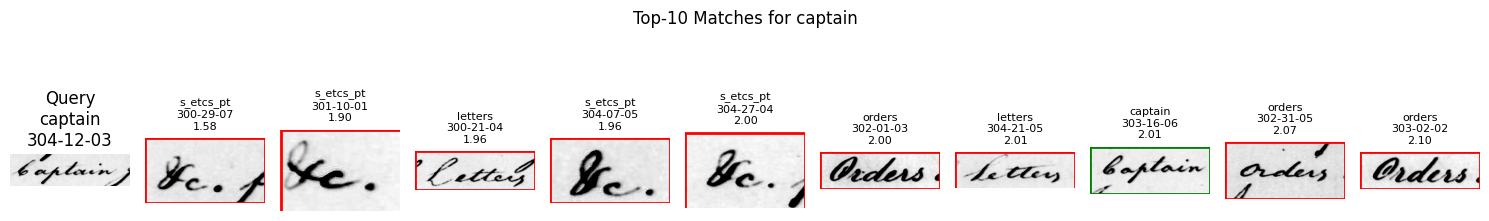

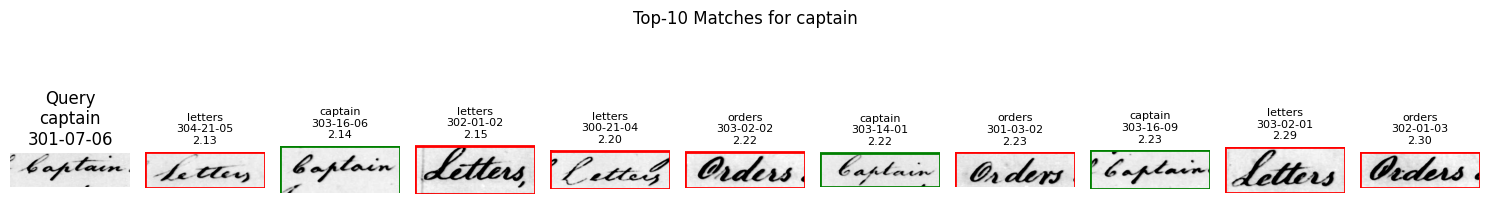

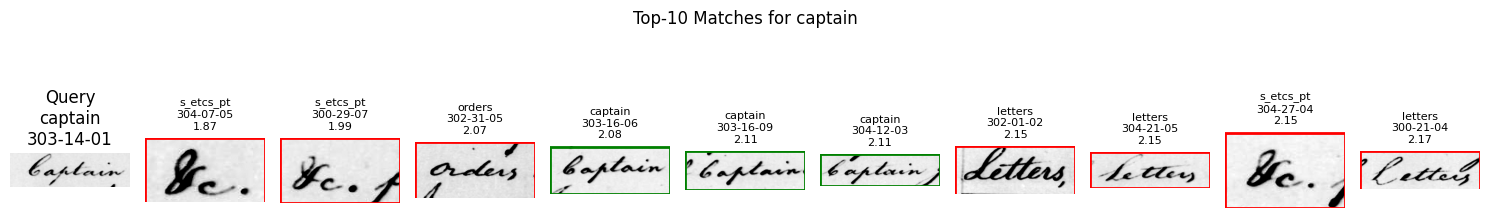

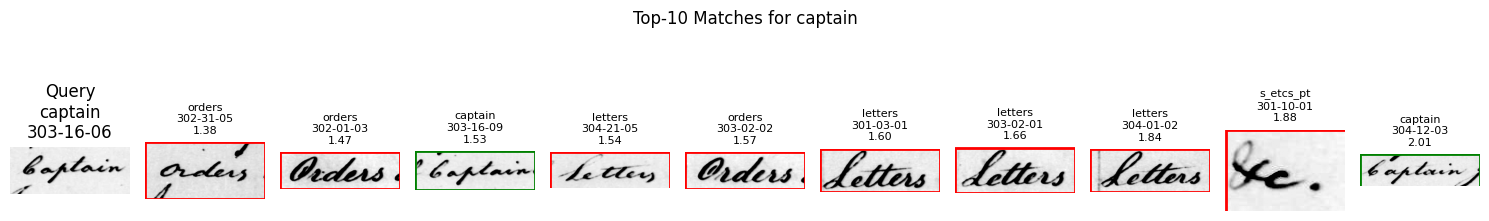

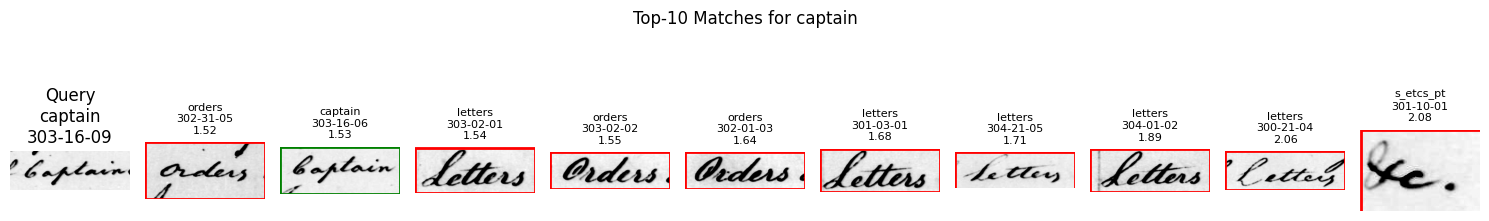

In [193]:
show_top_matches(results, num_queries=5, top_k=10)

## TEST

Author: Nathan Wegmann (Adapted from Kaushik Raghupathruni)

In [194]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from PIL import Image, ImageEnhance
from skimage.feature import hog
import cv2
import xml.etree.ElementTree as ET
from svgpathtools import parse_path
from collections import defaultdict
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [195]:
# Paths
TEST = Path("dataset/test")
TEST_PAGES_DIR = TEST / "images"
TEST_SVG_DIR = TEST / "locations"
TEST_INDEX_TSV = TEST / "transcription.tsv"
TEST_KEYWORDS_TSV = TEST / "keywords.tsv"
TEST_KEYWORDS_DIR = TEST / "keywords"
TEST_WORDS_DIR = TEST / "words"
TEST_KEYWORDS_DIR.mkdir(parents=True, exist_ok=True)
TEST_WORDS_DIR.mkdir(parents=True, exist_ok=True)
TEST_PATH = TEST / "test.tsv"

Create list of keywords:

In [196]:
# Load splits
test_pages = set(line.strip() for line in TEST_PATH.open())


# Initialize index list
index = []

# Load keywords and build index from KEYWORDS_TSV
with TEST_KEYWORDS_TSV.open() as f:
    for line in f:
        # Split the line by space to separate the hyphenated word and locator
        parts = line.strip().split('\t', 1)

        if len(parts) == 2:
            hyphenated_word, locator = parts
            
            # Remove hyphens from the word
            word = hyphenated_word.replace('-', '')
            
            # Clean the word
            cleaned_word = clean_word(word)
            
            if cleaned_word:  # Skip empty strings
                index.append({
                    'id': locator,  # Use the locator code (e.g., "271-04-07")
                    'keyword': cleaned_word
                })
print(index)

[{'id': '271-04-07', 'keyword': 'virginia'}, {'id': '271-17-07', 'keyword': 'order'}, {'id': '272-21-01', 'keyword': 'will'}, {'id': '300-02-06', 'keyword': 'december'}, {'id': '271-08-05', 'keyword': 'you'}, {'id': '271-24-03', 'keyword': 'which'}, {'id': '273-26-02', 'keyword': 'them'}, {'id': '273-35-10', 'keyword': 'have'}, {'id': '274-11-04', 'keyword': 'for'}, {'id': '276-21-03', 'keyword': 'recruits'}]


Populate keywords folder with cropped keywords images:

In [197]:
for rec in tqdm(index):
    locator = rec["id"]
    word = rec["keyword"]
    page = locator.split("-", 1)[0]
    svg_path = SVG_DIR / f"{page}.svg"
    jpg_path = PAGES_DIR / f"{page}.jpg"

    try:
        xywh_svg = bbox_from_svg(svg_path, locator)
        x, y, w, h = svg_to_pixel_coords(svg_path, jpg_path, xywh_svg)
        img = Image.open(jpg_path).convert("L")
        crop = img.crop((x, y, x+w, y+h))

        # Improve constrast
        crop = ImageEnhance.Contrast(crop).enhance(2.0)

        dest_dir = TEST_KEYWORDS_DIR / word
        dest_dir.mkdir(exist_ok=True)
        out_path = dest_dir / f"{locator}.png"
        crop.save(out_path)
    except Exception as e:
        print(f"Failed {locator}: {e}")

100%|██████████| 10/10 [00:00<00:00, 60.55it/s]


Populate words folder with words images from test images:

In [198]:
for page in test_pages:
    svg_path = TEST_SVG_DIR / f"{page}.svg"
    jpg_path = TEST_PAGES_DIR / f"{page}.jpg"
    
    # Parse the SVG file
    svg_tree = ET.parse(str(svg_path))
    
    # Find all elements with 'id' attribute (these are likely your bboxes)
    for elem in svg_tree.iter():
        if 'id' in elem.attrib:
            locator = elem.attrib['id']
            
            try:
                # Extract bounding box
                xywh_svg = bbox_from_svg(svg_path, locator)
                x, y, w, h = svg_to_pixel_coords(svg_path, jpg_path, xywh_svg)
                
                # Open and crop the image
                img = Image.open(jpg_path).convert("L")
                crop = img.crop((x, y, x+w, y+h))
                
                # Improve contrast
                crop = ImageEnhance.Contrast(crop).enhance(2.0)
                
                # Create a directory for storing all extracted boxes
                dest_dir = TEST_WORDS_DIR
                dest_dir.mkdir(parents=True, exist_ok=True)
                
                # Save the cropped image using just the locator as the filename
                out_path = dest_dir / f"{locator}.png"
                crop.save(out_path)
                
            except Exception as e:
                print(f"Failed {locator} in {page}: {e}")

In [199]:
# Feature Extraction
keywords_data = []
for word_dir in TEST_KEYWORDS_DIR.iterdir():
    label = word_dir.name
    
    for img_path in word_dir.glob("*.png"):
        locator = img_path.stem
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            
            # Check if image was loaded successfully
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
                
            
            bw = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 15, 11)
            bw = cv2.resize(bw, (100, 100), interpolation=cv2.INTER_NEAREST)
            win_feats = extract_window_features(bw)
            hog_feats = extract_hog_features(bw)
            min_len = min(len(win_feats), len(hog_feats))
            seq = np.concatenate([win_feats[:min_len], hog_feats[:min_len]], axis=1)
            seq = z_normalize_features(seq)
            seq = pad_or_trim_sequence(seq)
            
            keywords_data.append((img_path.name, label, seq))

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            import traceback
            traceback.print_exc()  # Print full traceback for better debugging

print(f"\nTotal keyword images processed: {len(keywords_data)}")


test_data = []
for img_path in TEST_WORDS_DIR.glob("*.png"):
        locator = img_path.stem
        
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            
            # Check if image was loaded successfully
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
            bw = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 15, 11)
            bw = cv2.resize(bw, (100, 100), interpolation=cv2.INTER_NEAREST)
            win_feats = extract_window_features(bw)
            hog_feats = extract_hog_features(bw)
            min_len = min(len(win_feats), len(hog_feats))
            seq = np.concatenate([win_feats[:min_len], hog_feats[:min_len]], axis=1)
            seq = z_normalize_features(seq)
            seq = pad_or_trim_sequence(seq)
            
            test_data.append((img_path.name, seq))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            import traceback
            traceback.print_exc()  # Print full traceback for better debugging

print(f"\nTotal word images processed: {len(test_data)}")


Total keyword images processed: 10

Total word images processed: 1167


In [200]:
# DTW Matching

test_results = {}
for query_fname, query_label, query_seq in tqdm(keywords_data, desc="DTW Matching"):
    distances = []
    for fname, seq in test_data:
        if fname == query_fname:
            continue
        # Optional prefilter: skip wildly different lengths
        if abs(len(query_seq) - len(seq)) > 20:
            continue
        dist = dtw_distance_with_sakoe_chiba(query_seq, seq, w=10)
        distances.append((fname, dist))
    distances.sort(key=lambda x: x[1])
    test_results[query_fname] = {
        "query_label": query_label,
        "matches": distances
    }

DTW Matching: 100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


In [203]:
def show_top_matches_test(results, num_queries=5, top_k=10):
    shown = 0
    for query_fname, result in results.items():
        query_label = result["query_label"]
        
        # Extract the locator for the query image
        query_parts = query_fname.split('.')
        query_locator = query_parts[0]  # e.g., "304-12-03"
        
        # Build the path to the query image including the word/label
        query_img_path = os.path.join(TEST_KEYWORDS_DIR, query_label, f"{query_locator}.png")
        query_img = cv2.imread(query_img_path, cv2.IMREAD_GRAYSCALE)
        
        if query_img is None:
            print(f"Warning: Could not find query image at {query_img_path}")
            continue
            
        matches = result["matches"][:top_k]
        fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 3))
        axes[0].imshow(query_img, cmap='gray')
        axes[0].set_title(f"Query\n{query_label}\n{query_locator}")
        axes[0].axis('off')
        for i, (fname, dist) in enumerate(matches):
            # Extract the locator for the match image
            match_parts = fname.split('.')
            match_locator = match_parts[0]  # e.g., "301-07-06"
    
            match_img_path = os.path.join(TEST_WORDS_DIR, f"{match_locator}.png")
            match_img = cv2.imread(match_img_path, cv2.IMREAD_GRAYSCALE)
            
            if match_img is None:
                print(f"Warning: Could not find match image at {match_img_path}")
                axes[i + 1].text(0.5, 0.5, "Image not found", 
                                ha='center', va='center', fontsize=8)
                axes[i + 1].set_title(f"{match_locator}\n{dist:.2f}", fontsize=8)
                axes[i + 1].axis('off')
                continue
                
            axes[i + 1].imshow(match_img, cmap='gray')
            axes[i + 1].set_title(f"{match_locator}\n{dist:.2f}", fontsize=8)
            axes[i + 1].axis('off')
            
            
        plt.suptitle(f"Top-{top_k} Matches for {query_label}", fontsize=12)
        plt.tight_layout()
        plt.show()
        
        shown += 1
        if shown >= num_queries:
            break

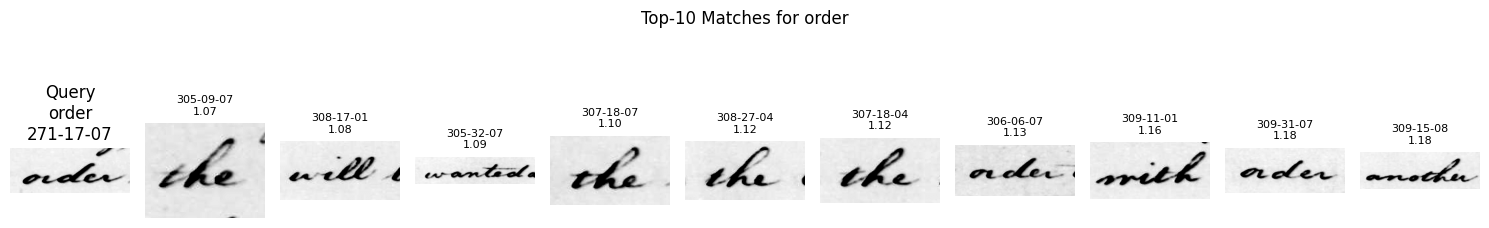

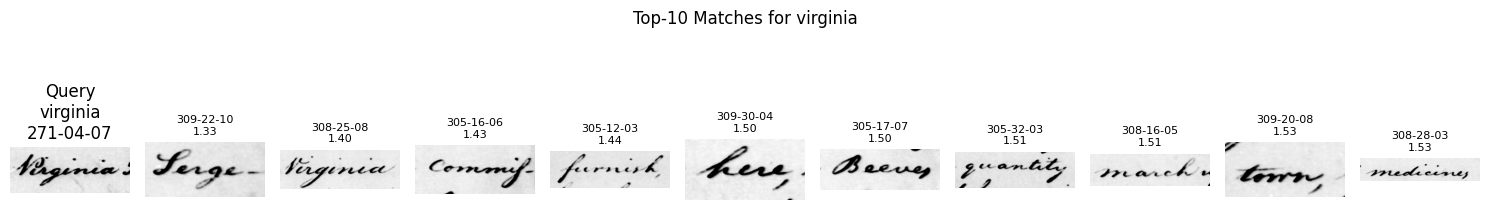

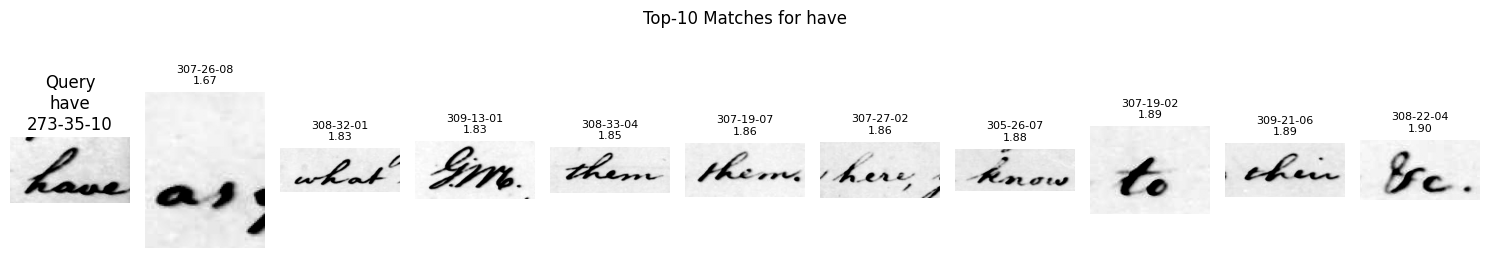

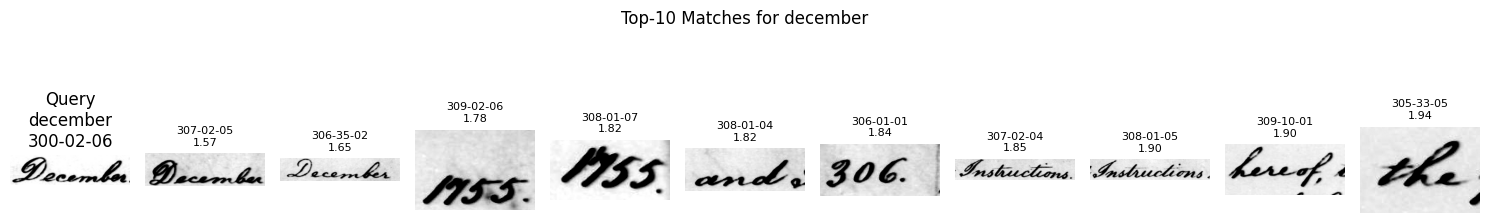

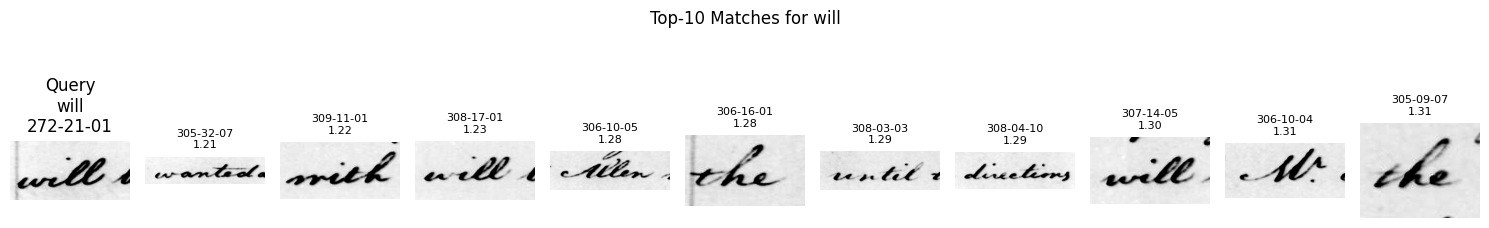

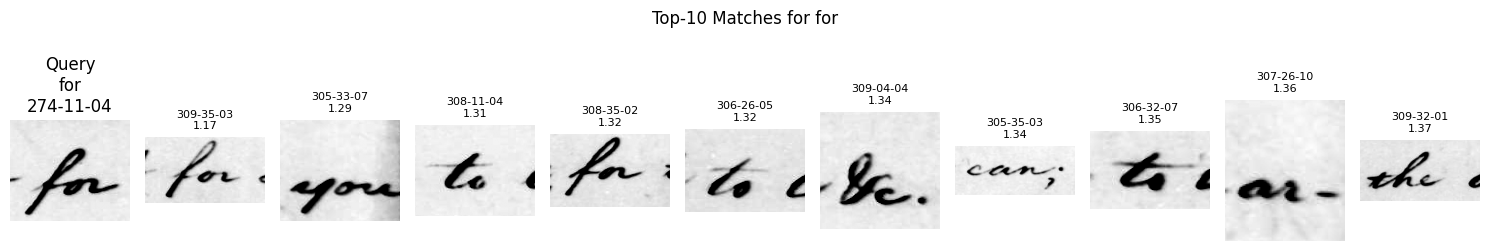

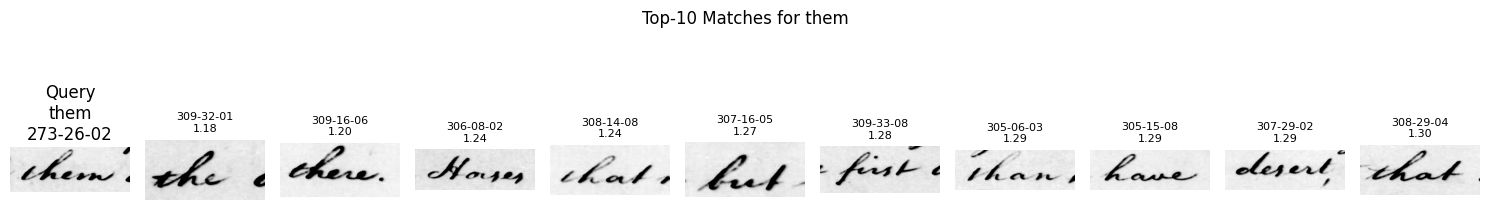

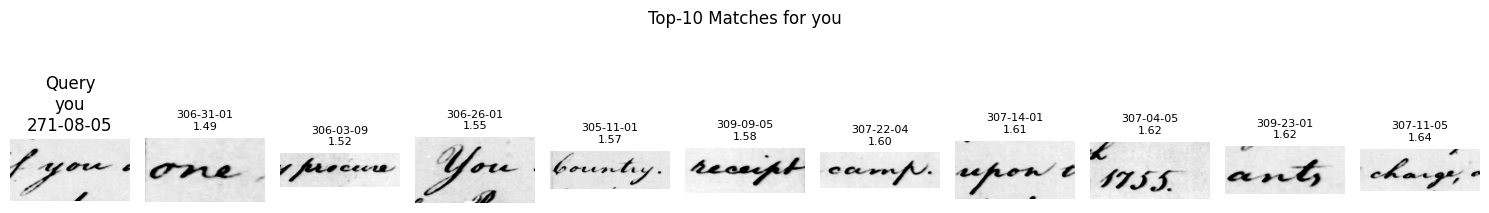

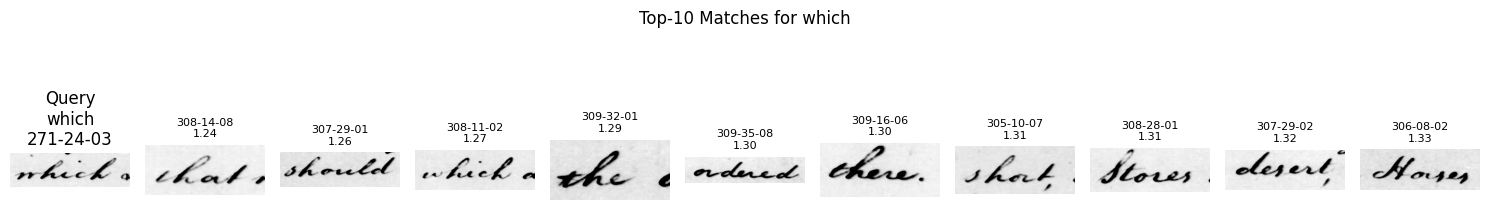

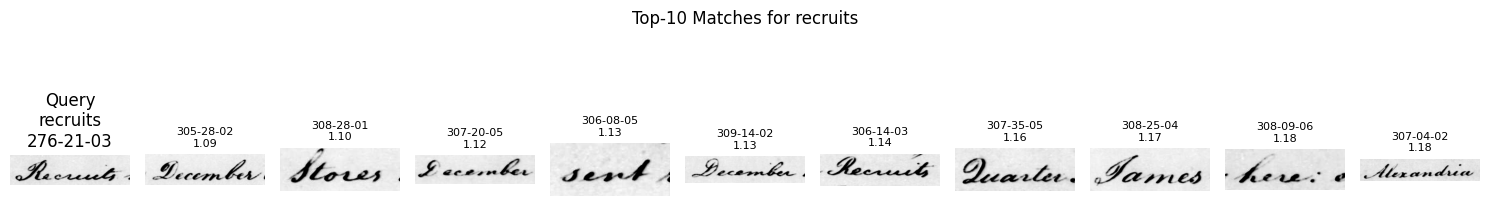

In [204]:
show_top_matches_test(test_results, num_queries=25, top_k=10)

In [205]:
def create_submission_tsv(test_results, output_file="test.tsv"):
    # Open the output file
    with open(output_file, "w") as f:
        for keyword, values in test_results.items():
            matches = sorted(values["matches"][:-1], key=lambda x: x[1])
            line = f"{keyword.replace(".png", "")}"
            for match in matches:
                test_fname, distance = match
                # Remove .png extension if present
                test_id = test_fname.replace(".png", "")
                line += f"\t{test_id}\t{distance}"

            
            # Write the line to the file
            f.write(line + "\n")
        print(f"Submission file {output_file} created successfully.")

create_submission_tsv(test_results)

Submission file test.tsv created successfully.
